# Load & Preprocessing

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

dataset_path = 'datasets/WELFake_Dataset.csv'
combined_df = pd.read_csv(dataset_path)

In [2]:
combined_df['label'] = combined_df['label'].replace({0: 'Fake', 1: 'True'})
combined_df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,True
1,1,NaN,Did they post their votes for Hillary already?,True
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",True
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,Fake
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",True


In [3]:
combined_df['label'].value_counts()
# drop rows with nAn values
combined_df = combined_df.dropna()


# EDA

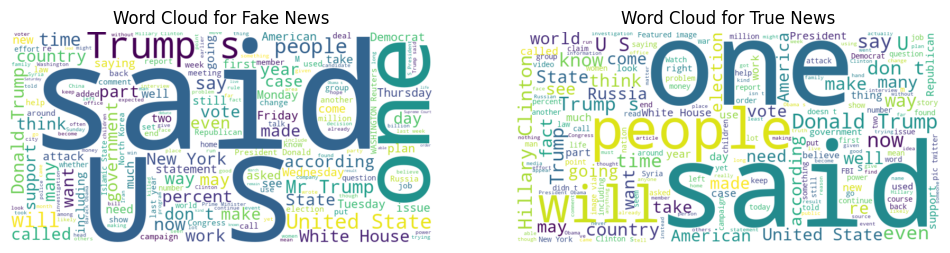

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fake_news_text = ' '.join(combined_df[combined_df['label'] == 'Fake']['text'].astype(str))
true_news_text = ' '.join(combined_df[combined_df['label'] == 'True']['text'].astype(str))

fake_news_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_news_text)
true_news_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_news_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(fake_news_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(true_news_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for True News')
plt.axis('off')

plt.show()

In [5]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

fake_news_words = combined_df[combined_df['label'] == 'Fake']['text'].astype(str).apply(preprocess_text).explode()
true_news_words = combined_df[combined_df['label'] == 'True']['text'].astype(str).apply(preprocess_text).explode()

fake_news_word_counts = Counter(fake_news_words)
true_news_word_counts = Counter(true_news_words)

print("Most Common Words in Fake News:")
print(fake_news_word_counts.most_common(10))
print("\nMost Common Words in True News:")
print(true_news_word_counts.most_common(10))

ModuleNotFoundError: No module named 'nltk'

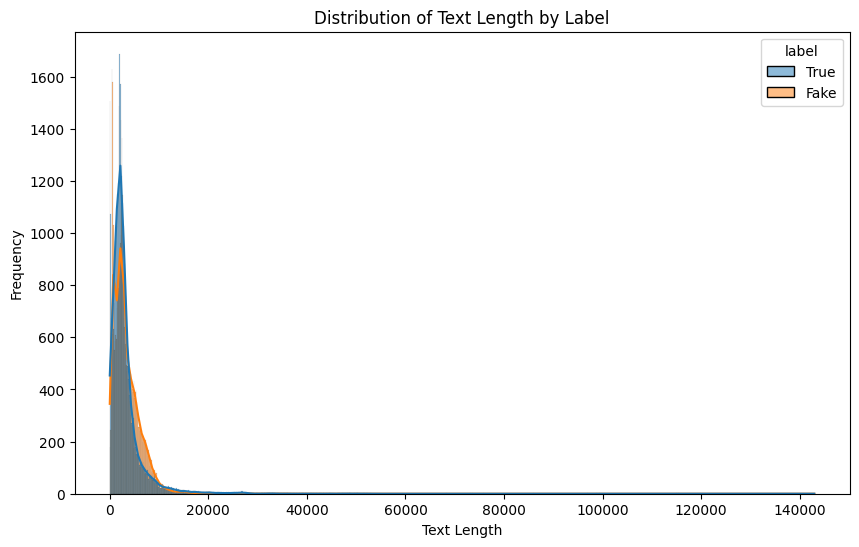


Descriptive Statistics of Text Length by Label:
         count         mean          std  min     25%     50%      75%  \
label                                                                    
Fake   35028.0  3495.210660  3324.982167  1.0  1477.0  2642.5  4757.25   
True   36509.0  3098.319592  4085.848844  1.0  1364.0  2235.0  3456.00   

            max  
label            
Fake    85948.0  
True   142961.0  


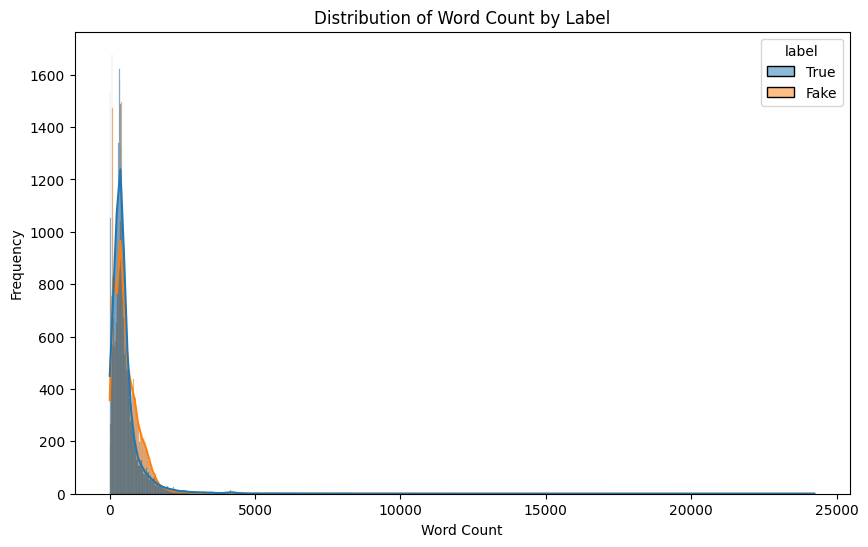


Descriptive Statistics of Word Count by Label:
         count        mean         std  min    25%    50%    75%      max
label                                                                    
Fake   35028.0  577.615536  563.115638  0.0  241.0  427.0  783.0  14641.0
True   36509.0  512.850886  680.010437  0.0  225.0  373.0  573.0  24234.0


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the length of the news articles
combined_df = combined_df.dropna(subset=['text'])
combined_df['text_length'] = combined_df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(combined_df, x='text_length', hue='label', kde=True)
plt.title('Distribution of Text Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

print("\nDescriptive Statistics of Text Length by Label:")
print(combined_df.groupby('label')['text_length'].describe())

# Distribution of the number of words in the news articles
combined_df['word_count'] = combined_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(combined_df, x='word_count', hue='label', kde=True)
plt.title('Distribution of Word Count by Label')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

print("\nDescriptive Statistics of Word Count by Label:")
print(combined_df.groupby('label')['word_count'].describe())

# SVM

## Train Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Combine 'title' and 'text' columns
combined_df['combined_text'] = combined_df['title'].fillna('') + ' ' + combined_df['text'].fillna('')

# Prepare the data
X = combined_df['combined_text']
y = combined_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into numerical vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train the Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)



## Predict and calculate metrics

In [ ]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the Test Set: {accuracy:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Fake', 'True'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Analyze which class is predicted better and worse
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identify which class is predicted worse (higher misclassification rate)
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")

In [ ]:
# Create a DataFrame with the test data and predictions
predictions_df = pd.DataFrame({'text': X_test, 'actual_label': y_test, 'predicted_label': y_pred})

# Filter for false positives (Fake classified as True)
false_positives = predictions_df[(predictions_df['actual_label'] == 'Fake') & (predictions_df['predicted_label'] == 'True')]

# Filter for false negatives (True classified as Fake)
false_negatives = predictions_df[(predictions_df['actual_label'] == 'True') & (predictions_df['predicted_label'] == 'Fake')]

print("\nExamples of False Positives (Fake News Classified as True):\n")
if not false_positives.empty:
    for index, row in false_positives.head(5).iterrows():
        print(f"Text: {row['text'][:200]}...")
        print(f"Actual Label: {row['actual_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print("-" * 50)
else:
    print("No false positives found.")

print("\nExamples of False Negatives (True News Classified as Fake):\n")
if not false_negatives.empty:
    for index, row in false_negatives.head(5).iterrows():
        print(f"Text: {row['text'][:200]}...")
        print(f"Actual Label: {row['actual_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print("-" * 50)
else:
    print("No false negatives found.")


Examples of False Positives (Fake News Classified as True):

Text:  Energy Department To Close Office Of International Climate And Technology In response to the U.S. withdrawing from the Paris climate agreement earlier this month, the Energy Department is shutting do...
Actual Label: Fake
Predicted Label: True
--------------------------------------------------
Text: PALESTINIANS STEPPING UP STABBINGS: Dramatic Video Shows Palestinian Man Stabbing Israeli Police Officers…Israeli Teen Stabbed On Bicycle ***Warning*** Graphic photo and videoThank goodness Israeli s ...
Actual Label: Fake
Predicted Label: True
--------------------------------------------------
Text: DISGUSTING! SEATTLE MAYOR WHO Announced He’s Suing Trump Over Sanctuary City Exec Order Is Accused Of Raping 15-Yr Old Boy, Two Others Ed Murray has just been accused of alleged sexual assault of teen...
Actual Label: Fake
Predicted Label: True
--------------------------------------------------
Text: N. KOREA’S LATEST MISSILE 